In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator

In [9]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()


In [10]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_test/=255


In [11]:
number_of_classes = 10

Y_train = np_utils.to_categorical(y_train, number_of_classes)
Y_test = np_utils.to_categorical(y_test, number_of_classes)

In [12]:

X_train = X_train[0:6000]
Y_train = Y_train[0:6000]

In [13]:
# Three steps to create a CNN


model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))

model.add(Activation('softmax'))

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [15]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [16]:
train_generator = gen.flow(X_train, Y_train, batch_size=64)
test_generator = test_gen.flow(X_test, Y_test, batch_size=64)

### Note here, I use 6000/64 steps per epoch

In [17]:
model.fit_generator(train_generator, steps_per_epoch=6000//64, epochs=5, 
                    validation_data=test_generator, validation_steps=10000//64)

Epoch 1/5
93/93 [==============================] - 30s 325ms/step - loss: 0.4450 - accuracy: 0.8560 - val_loss: 5.2234 - val_accuracy: 0.1134
Epoch 2/5
93/93 [==============================] - 29s 310ms/step - loss: 0.1410 - accuracy: 0.9591 - val_loss: 1.5551 - val_accuracy: 0.6643
Epoch 3/5
93/93 [==============================] - 30s 323ms/step - loss: 0.1060 - accuracy: 0.9690 - val_loss: 5.5026 - val_accuracy: 0.0976
Epoch 4/5
93/93 [==============================] - 32s 339ms/step - loss: 0.0845 - accuracy: 0.9747 - val_loss: 1.7232 - val_accuracy: 0.3748
Epoch 5/5
93/93 [==============================] - 34s 369ms/step - loss: 0.0717 - accuracy: 0.9791 - val_loss: 0.1937 - val_accuracy: 0.9145


In [18]:

score = model.evaluate(X_test, Y_test)
print()
print('Test accuracy: ', score[1])

10000/10000 [==============================] - 9s 880us/step

Test accuracy:  0.9146000146865845


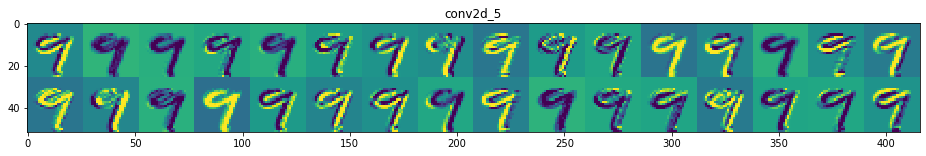

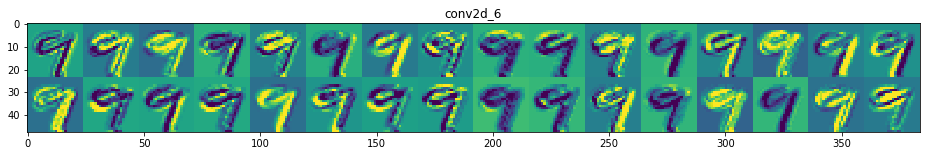

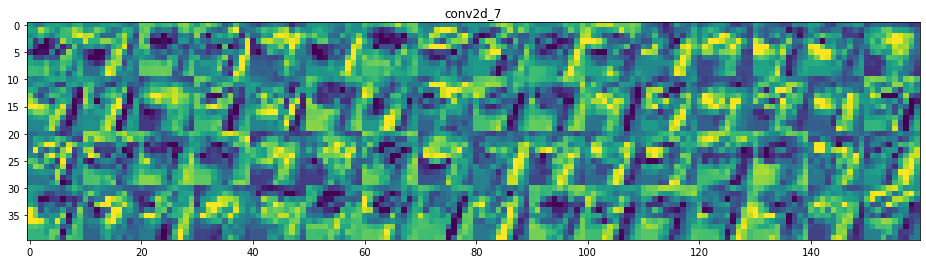

In [25]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)       

In [22]:
test_im = X_train[154]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


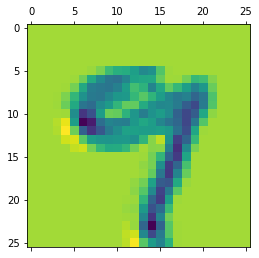

In [23]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input=model.input, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')